In [15]:
import collections
import math
import sys
from pathlib import Path
import argparse

import httpagentparser
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import redis
import seaborn as sns
from scipy.stats import binom_test, linregress, pearsonr, spearmanr
from sklearn import metrics

plt.style.reload_library()
plt.style.use(['science'])

sys.path.insert(0, ".")
from edit_image import parameter_range
from IA import utils

In [16]:
submission_csv = Path("survey") / "survey.csv" 
plot_dir = Path("analysis")  / "survey" / "users"  

In [17]:
if False:
    submission_csv = Path("survey") / "survey_NIMA.csv" 
    plot_dir = Path("analysis")  / "survey" / "NIMA"  

In [18]:
(plot_dir / "small_vs").mkdir(parents=True, exist_ok=True)

In [19]:
sub_df = pd.read_csv(submission_csv)
sub_df

,RTT(s),img,parameter,leftChanges,rightChanges,chosen,hashval,screenWidth,screenHeight,windowWidth,windowHeight,colorDepth,userid,count,useragent
0,42,/img/pexels-photo-3625576.jpeg,saturation,0.8,0.0,leftImage,-2967711091583063552,2560,1440,2543,1329,24,14d0562bfc0244a5a75a9d85cdcb413e,1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1,28,/img/pexels-photo-2138018.jpeg,contrast,0.0,-0.6,leftImage,8038884434063143936,2560,1440,2543,1329,24,14d0562bfc0244a5a75a9d85cdcb413e,2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2,10,/img/pexels-photo-860257.jpeg,exposure,0.0,0.6,leftImage,5013199214896521216,2560,1440,2543,1329,24,14d0562bfc0244a5a75a9d85cdcb413e,3,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,7,/img/pexels-photo-938044.jpeg,vibrance,20.0,25.0,unsure,-3067968659255084032,2560,1440,2543,1329,24,14d0562bfc0244a5a75a9d85cdcb413e,4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,2,/img/pexels-photo-1848569.jpeg,exposure,0.0,3.0,leftImage,7738852184068067328,2560,1440,2543,1329,24,892305c88679733916ad72e2f308fe4b,1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,2,/img/pexels-photo-2852270.jpeg,brightness,0.0,-0.8,leftImage,5963833270994264064,2560,1440,2543,1329,24,d9991bed63a7ae6b35e70301c04945a9,297,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
8120,3,/img/cowboy-ronald-reagan-cowboy-hat-hat-41008...,highlights,-100.0,-50.0,unsure,-890440748975655168,2560,1440,2543,1329,24,d9991bed63a7ae6b35e70301c04945a9,298,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
8121,3,/img/pexels-photo-1170412.jpeg,lcontrast,0.0,30.0,leftImage,-1944968464250125056,2560,1440,2543,1329,24,d9991bed63a7ae6b35e70301c04945a9,299,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
8122,2,/img/pexels-photo-3560139.jpeg,exposure,3.0,0.0,rightImage,-2986414488693132800,2560,1440,2543,1329,24,d9991bed63a7ae6b35e70301c04945a9,300,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [20]:
sub_df["leftChanges"] = sub_df.apply(lambda row: min(utils.parameter_range[row["parameter"]]["range"], key=lambda x:abs(x-row["leftChanges"])), axis=1)
sub_df["rightChanges"] = sub_df.apply(lambda row: min(utils.parameter_range[row["parameter"]]["range"], key=lambda x:abs(x-row["rightChanges"])), axis=1)

In [21]:
print(f"{sub_df.hashval.count()} images compared in {sub_df.groupby('userid').userid.count().count()} sessions")
sub_df.groupby("chosen").chosen.count()

8124 images compared in 73 sessions


chosen
error           92
leftImage     3187
rightImage    2995
unsure        1850
Name: chosen, dtype: int64

In [22]:
if "leftNIMA" in sub_df.columns and "rightNIMA" in sub_df.columns:
    sub_df["chosen"] = sub_df.apply(lambda row: "leftImage" if row.leftNIMA > row.rightNIMA else "rightImage", axis=1)

In [23]:
sub_df["default"] = sub_df.apply(lambda row: parameter_range[row.parameter]["default"], axis=1)
sub_df["leftChanges"] = sub_df.apply(lambda row: float(row.leftChanges), axis=1)
sub_df["rightChanges"] = sub_df.apply(lambda row: float(row.rightChanges), axis=1)
sub_df["leftChanges"] = sub_df.apply(lambda row: 0 if math.isclose(row.leftChanges, 0) else row.leftChanges, axis=1)
sub_df["rightChanges"] = sub_df.apply(lambda row: 0 if math.isclose(row.rightChanges, 0) else row.rightChanges, axis=1)
sub_df["leftChanges"] = sub_df.apply(lambda row: row.default if math.isclose(row.leftChanges, row.default) else row.leftChanges, axis=1)
sub_df["rightChanges"] = sub_df.apply(lambda row: row.default if math.isclose(row.rightChanges, row.default) else row.rightChanges, axis=1)
sub_df["leftChanges"] = sub_df.apply(lambda row: round(row.leftChanges, 2), axis=1)
sub_df["rightChanges"] = sub_df.apply(lambda row: round(row.rightChanges, 2), axis=1)
sub_df["bothSame"] = sub_df.apply(lambda row: math.isclose(row.leftChanges, row.rightChanges), axis=1)

sub_df["lRelDistDefault"] = sub_df.apply(lambda row: abs((row.default) - (row.leftChanges)), axis=1)
sub_df["rRelDistDefault"] = sub_df.apply(lambda row: abs((row.default) - (row.rightChanges)), axis=1)
sub_df["lRelDistDefault"] = sub_df.apply(lambda row: 0 if math.isclose(row.lRelDistDefault, 0) else row.lRelDistDefault, axis=1)
sub_df["rRelDistDefault"] = sub_df.apply(lambda row: 0 if math.isclose(row.rRelDistDefault, 0) else row.rRelDistDefault, axis=1)
sub_df["lRelDistDefault"] = sub_df.apply(lambda row: round(row.lRelDistDefault, 2), axis=1)
sub_df["rRelDistDefault"] = sub_df.apply(lambda row: round(row.rRelDistDefault, 2), axis=1)
sub_df["smallChange"] = sub_df.apply(lambda row: row.leftChanges if row.lRelDistDefault < row.rRelDistDefault else row.rightChanges, axis=1)
sub_df["largeChange"] = sub_df.apply(lambda row: row.rightChanges if row.lRelDistDefault < row.rRelDistDefault else row.leftChanges, axis=1)
sub_df["smallRelDistDefault"] = sub_df.apply(lambda row: min(row.lRelDistDefault, row.rRelDistDefault), axis=1)
sub_df["largeRelDistDefault"] = sub_df.apply(lambda row: max(row.lRelDistDefault, row.rRelDistDefault), axis=1)
sub_df["smallLargeRelDistDefault"] = sub_df.apply(lambda row: abs((row.smallRelDistDefault) - (row.largeRelDistDefault)), axis=1)
sub_df["smallLargeRelDistDefault"] = sub_df.apply(lambda row: 0 if math.isclose(row.smallLargeRelDistDefault, 0) else row.smallLargeRelDistDefault, axis=1)
sub_df["smallLargeRelDistDefault"] = sub_df.apply(lambda row: round(row.smallLargeRelDistDefault, 2), axis=1)
sub_df["changeSign"] = sub_df.apply(lambda row: 0 if math.isclose(row.largeChange - row.default, 0) else row.largeChange - row.default, axis=1)
sub_df["changeSign"] = sub_df.apply(lambda row: np.sign(row.changeSign), axis=1)

sub_df["smallChangeIsOriginal"] = sub_df.apply(lambda row: math.isclose(row.smallChange, row.default), axis=1)

sub_df["smallerChosen"] = sub_df.apply(lambda row: not row.bothSame and ((math.isclose(row.smallChange, row.leftChanges) and row.chosen == "leftImage") or math.isclose(row.smallChange, row.rightChanges) and row.chosen == "rightImage"), axis=1)
sub_df["largerChosen"] = sub_df.apply(lambda row: not row.bothSame and ((math.isclose(row.largeChange, row.leftChanges) and row.chosen == "leftImage") or math.isclose(row.largeChange, row.rightChanges) and row.chosen == "rightImage"), axis=1)

In [24]:
if "leftNIMA" in sub_df.columns and "rightNIMA" in sub_df.columns:
    sub_df["chosenNIMA"] = sub_df.apply(lambda row: "leftImage" if row.leftNIMA > row.rightNIMA else "rightImage", axis=1)
    sub_df["sameNIMA"] = sub_df.apply(lambda row: row.chosen == row.chosenNIMA, axis=1)

In [25]:
clean_df = sub_df[sub_df.chosen != "error"]
clean_df

,RTT(s),img,parameter,leftChanges,rightChanges,chosen,hashval,screenWidth,screenHeight,windowWidth,...,rRelDistDefault,smallChange,largeChange,smallRelDistDefault,largeRelDistDefault,smallLargeRelDistDefault,changeSign,smallChangeIsOriginal,smallerChosen,largerChosen
0,42,/img/pexels-photo-3625576.jpeg,saturation,0.8,0.0,leftImage,-2967711091583063552,2560,1440,2543,...,0.0,0.0,0.8,0.0,0.8,0.8,1.0,True,False,True
1,28,/img/pexels-photo-2138018.jpeg,contrast,0.0,-0.6,leftImage,8038884434063143936,2560,1440,2543,...,0.6,0.0,-0.6,0.0,0.6,0.6,-1.0,True,True,False
2,10,/img/pexels-photo-860257.jpeg,exposure,0.0,0.6,leftImage,5013199214896521216,2560,1440,2543,...,0.6,0.0,0.6,0.0,0.6,0.6,1.0,True,True,False
3,7,/img/pexels-photo-938044.jpeg,vibrance,20.0,25.0,unsure,-3067968659255084032,2560,1440,2543,...,0.0,25.0,20.0,0.0,5.0,5.0,-1.0,True,False,False
4,2,/img/pexels-photo-1848569.jpeg,exposure,0.0,3.0,leftImage,7738852184068067328,2560,1440,2543,...,3.0,0.0,3.0,0.0,3.0,3.0,1.0,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,2,/img/pexels-photo-2852270.jpeg,brightness,0.0,-0.8,leftImage,5963833270994264064,2560,1440,2543,...,0.8,0.0,-0.8,0.0,0.8,0.8,-1.0,True,True,False
8120,3,/img/cowboy-ronald-reagan-cowboy-hat-hat-41008...,highlights,-100.0,-50.0,unsure,-890440748975655168,2560,1440,2543,...,0.0,-50.0,-100.0,0.0,50.0,50.0,-1.0,True,False,False
8121,3,/img/pexels-photo-1170412.jpeg,lcontrast,0.0,30.0,leftImage,-1944968464250125056,2560,1440,2543,...,30.0,0.0,30.0,0.0,30.0,30.0,1.0,True,True,False
8122,2,/img/pexels-photo-3560139.jpeg,exposure,3.0,0.0,rightImage,-2986414488693132800,2560,1440,2543,...,0.0,0.0,3.0,0.0,3.0,3.0,1.0,True,True,False


In [26]:
nestedDict = lambda: collections.defaultdict(nestedDict)  # infinitely deep dict

chosenAsSmaller = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
chosenAsLarger = collections.defaultdict(lambda: collections.defaultdict(lambda: []))

for row in clean_df.itertuples():
    if row.bothSame or row.chosen=="unsure":
        continue
    if row.smallerChosen:
        if row.chosen == "leftImage":
            chosenAsSmaller[row.parameter][row.leftChanges].append(1)
            chosenAsLarger[row.parameter][row.rightChanges].append(0)
        elif row.chosen == "rightImage":
            chosenAsSmaller[row.parameter][row.rightChanges].append(1)
            chosenAsLarger[row.parameter][row.leftChanges].append(0)
    else:
        if row.chosen == "leftImage":
            chosenAsLarger[row.parameter][row.leftChanges].append(1)
            chosenAsSmaller[row.parameter][row.rightChanges].append(0)
        elif row.chosen == "rightImage":
            chosenAsLarger[row.parameter][row.rightChanges].append(1)
            chosenAsSmaller[row.parameter][row.leftChanges].append(0)

In [53]:
for param in parameter_range.keys():

    for change in chosenAsSmaller[param].keys():
        chosenAsSmaller[param][change] = np.mean(chosenAsSmaller[param][change])

    for change in chosenAsLarger[param].keys():
        chosenAsLarger[param][change] = np.mean(chosenAsLarger[param][change])

    try:
        x, y = zip(*sorted([(k,v) for k,v in chosenAsLarger[param].items() if k < parameter_range[param]["default"]]))
        x = list(x)
        y = list(y)
        plt.plot(x, y, "-x", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    except:
        pass
    
    try:
        x, y = zip(*sorted([(k,v) for k,v in chosenAsLarger[param].items() if k > parameter_range[param]["default"]]))
        x = list(x)
        y = list(y)
        plt.plot(x, y, "-x", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    except:
        pass

    x, y = zip(*sorted(chosenAsSmaller[param].items()))
    x = list(x)
    y = list(y)
    plt.plot(x, y, "-x", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])

    plt.hlines(y=0.5, xmin=min(parameter_range[param]["range"]), xmax=max(parameter_range[param]["range"]), linestyle="--", color="grey")
    plt.vlines(x=parameter_range[param]["default"],ymin=0, ymax=1, linestyle="--", color="orange")

    plt.ylabel("clicked(\%)")
    plt.xlabel("change")

    plt.xlim(left=min(parameter_range[param]["range"]), right=max(parameter_range[param]["range"]))
    plt.ylim(bottom=0, top=1)

    plt.tight_layout()
    plt.savefig(plot_dir /"params" / (param + ".pdf"))
    plt.clf()

<Figure size 252x189 with 0 Axes>

In [28]:
nestedDict = lambda: collections.defaultdict(nestedDict)  # infinitely deep dict

chosenAtAll = collections.defaultdict(lambda: collections.defaultdict(lambda: []))

for row in clean_df.itertuples():
    if row.bothSame or row.chosen=="unsure":
        continue

    if not row.smallChangeIsOriginal:
        continue

    if row.chosen == "leftImage":
        chosenAtAll[row.parameter][row.leftChanges].append(1)
        chosenAtAll[row.parameter][row.rightChanges].append(0)
    elif row.chosen == "rightImage":
        chosenAtAll[row.parameter][row.rightChanges].append(1)
        chosenAtAll[row.parameter][row.leftChanges].append(0)

In [48]:
for param in parameter_range.keys():
    for change in chosenAtAll[param].keys():
        chosenAtAll[param][change] = np.mean(chosenAtAll[param][change])

    try:
        x, y = zip(*sorted([(k,v) for k,v in chosenAtAll[param].items() if k <= parameter_range[param]["default"]]))
        x = list(x)
        y = list(y)
        #plt.plot(x, y, "-x", color="blue")
        sns.regplot(x, y, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], marker="x")
    except:
        pass

    try:
        x, y = zip(*sorted([(k,v) for k,v in chosenAtAll[param].items() if k >= parameter_range[param]["default"]]))
        x = list(x)
        y = list(y)
        #plt.plot(x, y, "-x", color="blue")
        sns.regplot(x, y, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], marker="x")
    except:
        pass

    plt.hlines(y=0.5, xmin=min(parameter_range[param]["range"]), xmax=max(parameter_range[param]["range"]), linestyle="--", color="grey")
    plt.vlines(x=parameter_range[param]["default"],ymin=0, ymax=1, linestyle="--", color="orange")

    plt.ylabel("clicked(\%)")
    plt.xlabel("change")

    plt.xlim(left=min(parameter_range[param]["range"]), right=max(parameter_range[param]["range"]))
    plt.ylim(bottom=0, top=1)

    plt.tight_layout()
    plt.savefig(plot_dir /"orig_params" / (param + ".pdf"))
    plt.clf()

<Figure size 252x189 with 0 Axes>

In [50]:
clean_df.columns

Index(['RTT(s)', 'img', 'parameter', 'leftChanges', 'rightChanges', 'chosen',
       'hashval', 'screenWidth', 'screenHeight', 'windowWidth', 'windowHeight',
       'colorDepth', 'userid', 'count', 'useragent', 'default', 'bothSame',
       'lRelDistDefault', 'rRelDistDefault', 'smallChange', 'largeChange',
       'smallRelDistDefault', 'largeRelDistDefault',
       'smallLargeRelDistDefault', 'changeSign', 'smallChangeIsOriginal',
       'smallerChosen', 'largerChosen'],
      dtype='object')

In [15]:
analyzeDict = nestedDict()
for key in parameter_range.keys():
    analyzeDict[key]["overall"] = len(clean_df[clean_df.parameter == key])
    analyzeDict[key]["unsure_eq"] = len(clean_df[(clean_df.parameter == key) & (clean_df.bothSame == True) & (clean_df.chosen == "unsure")])
    analyzeDict[key]["not_unsure_eq"] = len(clean_df[(clean_df.parameter == key) & (clean_df.bothSame == True) & (clean_df.chosen != "unsure")])
    analyzeDict[key]["unsure_not_eq"] = len(clean_df[(clean_df.parameter == key) & (clean_df.bothSame == False) & (clean_df.chosen == "unsure")])

    tmp = clean_df[(clean_df.parameter == key) & (clean_df.bothSame == False) & (clean_df.chosen != "unsure")]
    analyzeDict[key]["smallerChosen"] = len(tmp[(tmp.smallerChosen == True)])
    analyzeDict[key]["smallerChosenOrigPresent"] = len(tmp[(tmp.smallerChosen == True) & (tmp.smallChangeIsOriginal == True)])
    analyzeDict[key]["largerChosen"] = len(tmp[(tmp.largerChosen == True)])
    analyzeDict[key]["largerChosenOrigPresent"] = len(tmp[(tmp.largerChosen == True) & (tmp.smallChangeIsOriginal == True)])

    d1 = tmp["leftChanges"].value_counts().to_dict()
    d2 = tmp["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["occuredChanges"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.chosen == "leftImage")]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.chosen == "rightImage")]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["chosenChanges"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.smallChangeIsOriginal == True)]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.smallChangeIsOriginal == True)]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["occuredChangesOrigPresent"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.smallChangeIsOriginal == True) & (tmp.chosen == "leftImage")]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.smallChangeIsOriginal == True) & (tmp.chosen == "rightImage")]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["chosenChangesOrigPresent"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}

    d1 = tmp[tmp.changeSign > 0]["leftChanges"].value_counts().to_dict()
    d2 = tmp[tmp.changeSign > 0]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["occuredChangesPos"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.changeSign > 0) & (tmp.chosen == "leftImage")]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.changeSign > 0) & (tmp.chosen == "rightImage")]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["chosenChangesPos"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.changeSign > 0) & (tmp.smallChangeIsOriginal == True)]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.changeSign > 0) & (tmp.smallChangeIsOriginal == True)]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["occuredChangesOrigPresentPos"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.changeSign > 0) & (tmp.smallChangeIsOriginal == True) & (tmp.chosen == "leftImage")]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.changeSign > 0) & (tmp.smallChangeIsOriginal == True) & (tmp.chosen == "rightImage")]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["chosenChangesOrigPresentPos"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}

    d1 = tmp[tmp.changeSign < 0]["leftChanges"].value_counts().to_dict()
    d2 = tmp[tmp.changeSign < 0]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["occuredChangesNeg"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.changeSign < 0) & (tmp.chosen == "leftImage")]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.changeSign < 0) & (tmp.chosen == "rightImage")]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["chosenChangesNeg"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.changeSign < 0) & (tmp.smallChangeIsOriginal == True)]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.changeSign < 0) & (tmp.smallChangeIsOriginal == True)]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["occuredChangesOrigPresentNeg"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}
    d1 = tmp[(tmp.changeSign < 0) & (tmp.smallChangeIsOriginal == True) & (tmp.chosen == "leftImage")]["leftChanges"].value_counts().to_dict()
    d2 = tmp[(tmp.changeSign < 0) & (tmp.smallChangeIsOriginal == True) & (tmp.chosen == "rightImage")]["rightChanges"].value_counts().to_dict()
    analyzeDict[key]["chosenChangesOrigPresentNeg"] = {k: d1.get(k, 0) + d2.get(k, 0) for k in set(d1.keys()).union(set(d2.keys()))}

    analyzeDict[key]["occuredRelChangesPos"] = tmp[tmp.changeSign > 0]["smallLargeRelDistDefault"].value_counts().to_dict()
    analyzeDict[key]["smallerChosenRelChangesPos"] = tmp[(tmp.changeSign > 0) & (tmp.smallerChosen == True)]["smallLargeRelDistDefault"].value_counts().to_dict()
    analyzeDict[key]["occuredRelChangesOrigPresentPos"] = tmp[(tmp.changeSign > 0) & (tmp.smallChangeIsOriginal == True)]["smallLargeRelDistDefault"].value_counts().to_dict()
    analyzeDict[key]["smallerChosenRelChangesOrigPresentPos"] = tmp[(tmp.changeSign > 0) & (tmp.smallerChosen == True) & (tmp.smallChangeIsOriginal == True)]["smallLargeRelDistDefault"].value_counts().to_dict()

    analyzeDict[key]["occuredRelChangesNeg"] = tmp[tmp.changeSign < 0]["smallLargeRelDistDefault"].value_counts().to_dict()
    analyzeDict[key]["smallerChosenRelChangesNeg"] = tmp[(tmp.changeSign < 0) & (tmp.smallerChosen == True)]["smallLargeRelDistDefault"].value_counts().to_dict()
    analyzeDict[key]["occuredRelChangesOrigPresentNeg"] = tmp[(tmp.changeSign < 0) & (tmp.smallChangeIsOriginal == True)]["smallLargeRelDistDefault"].value_counts().to_dict()
    analyzeDict[key]["smallerChosenRelChangesOrigPresentNeg"] = tmp[(tmp.changeSign < 0) & (tmp.smallerChosen == True) & (tmp.smallChangeIsOriginal == True)]["smallLargeRelDistDefault"].value_counts().to_dict()

    chosenVS = tmp.groupby(["smallerChosen", "smallChange", "largeChange"])[["smallerChosen"]].size().to_frame("size").reset_index()
    allComparisons = tmp.groupby(["smallChange", "largeChange"])[["smallChange"]].size().to_frame("size").reset_index()
    for _, row in chosenVS[chosenVS.smallerChosen == True].iterrows():
        if len(allComparisons[(allComparisons.smallChange == row["smallChange"]) & (allComparisons.largeChange == row["largeChange"])]) > 1:
            raise KeyError("what?")
        analyzeDict[key]["asSmallerChosenVS"][row["smallChange"]][row["largeChange"]] = row["size"] / allComparisons[(allComparisons.smallChange == row["smallChange"]) & (allComparisons.largeChange == row["largeChange"])].iloc[0]["size"]

    chosenVS = tmp.groupby(["largerChosen", "smallChange", "largeChange"])[["largerChosen"]].size().to_frame("size").reset_index()
    allComparisons = tmp.groupby(["smallChange", "largeChange"])[["largeChange"]].size().to_frame("size").reset_index()
    for _, row in chosenVS[chosenVS.largerChosen == True].iterrows():
        if len(allComparisons[(allComparisons.smallChange == row["smallChange"]) & (allComparisons.largeChange == row["largeChange"])]) > 1:
            raise KeyError("what?")
        analyzeDict[key]["asLargerChosenVS"][row["largeChange"]][row["smallChange"]] = row["size"] / allComparisons[(allComparisons.smallChange == row["smallChange"]) & (allComparisons.largeChange == row["largeChange"])].iloc[0]["size"]

    if "leftNIMA" in sub_df.columns and "rightNIMA" in sub_df.columns:
        analyzeDict[key]["sameNIMA"] = tmp["sameNIMA"].value_counts().to_dict()

    for corr in [
        ("smallerChosenRelChangesPos", "occuredRelChangesPos"),
        ("smallerChosenRelChangesOrigPresentPos", "occuredRelChangesOrigPresentPos"),
        ("smallerChosenRelChangesNeg", "occuredRelChangesNeg"),
        ("smallerChosenRelChangesOrigPresentNeg", "occuredRelChangesOrigPresentNeg"),
        ("chosenChangesPos", "occuredChangesPos"),
        ("chosenChangesOrigPresentPos", "occuredChangesOrigPresentPos"),
        ("chosenChangesNeg", "occuredChangesNeg"),
        ("chosenChangesOrigPresentNeg", "occuredChangesOrigPresentNeg"),
    ]:
        if "rel" in corr[0].lower():
            pass
        elif not "rel" in corr[0].lower():
            if "pos" in corr[0].lower():
                for change in [val for val in parameter_range[key]["range"] if val >= parameter_range[key]["default"]]:
                    if not change in analyzeDict[key][corr[0]]:
                        analyzeDict[key][corr[0]][change] = 0
                    if not change in analyzeDict[key][corr[1]]:
                        raise KeyError(f"that's weird: {key} {analyzeDict[key][corr[1]].keys()} {change}")
            elif "neg" in corr[0].lower():
                if len(analyzeDict[key][corr[0]]) > 1:  # lcontrast and vibrance
                    for change in [val for val in parameter_range[key]["range"] if val <= parameter_range[key]["default"]]:
                        if not change in analyzeDict[key][corr[0]]:
                            analyzeDict[key][corr[0]][change] = 0
                        if not change in analyzeDict[key][corr[1]]:
                            raise KeyError(f"that's weird: {key} {analyzeDict[key][corr[1]].keys()} {change}")
            else:
                raise NotImplementedError("you forgot what you thought wasn't necessary")
        else:
            raise "what?"

        for val in analyzeDict[key][corr[0]].keys():
            analyzeDict[key][corr[0]][val] /= analyzeDict[key][corr[1]][val]

In [17]:
params = sorted(parameter_range.keys(), key=lambda key: binom_test(analyzeDict[key]["smallerChosen"], n=analyzeDict[key]["smallerChosen"] + analyzeDict[key]["largerChosen"]))

In [19]:
for i, key in enumerate(params):
    print(f"{key}:\t{analyzeDict[key]['overall']} | {(analyzeDict[key]['overall'] / len(clean_df)) * 100}")
    print(
        "\tbinomial test overall w/o unsure:\tp: {:05.4f}".format(binom_test(analyzeDict[key]["smallerChosen"], n=analyzeDict[key]["smallerChosen"] + analyzeDict[key]["largerChosen"])),
        f"(x={analyzeDict[key]['smallerChosen']} | n={analyzeDict[key]['smallerChosen'] + analyzeDict[key]['largerChosen']})",
    )
    print(
        "\tbinomial test w/ orig. img. w/o unsure:\tp: {:05.4f}".format(binom_test(analyzeDict[key]["smallerChosenOrigPresent"], n=analyzeDict[key]["smallerChosenOrigPresent"] + analyzeDict[key]["largerChosenOrigPresent"])),
        f"(x={analyzeDict[key]['smallerChosenOrigPresent']} | n={analyzeDict[key]['smallerChosenOrigPresent'] + analyzeDict[key]['largerChosenOrigPresent']})",
    )
    if "leftNIMA" in sub_df.columns and "rightNIMA" in sub_df.columns:
            print("\tsurvey == NIMA: {:04.2f}%".format(analyzeDict[key]["sameNIMA"][True] / (analyzeDict[key]["sameNIMA"][True] + analyzeDict[key]["sameNIMA"][False]) * 100))

    print(f"\tsmaller edit:\t\t{'{:.1f}%'.format(analyzeDict[key]['smallerChosenOrigPresent'] / (analyzeDict[key]['smallerChosenOrigPresent'] + analyzeDict[key]['largerChosenOrigPresent']) * 100)}\t| {analyzeDict[key]['smallerChosenOrigPresent']}")
    print(f"\tlarger edit:\t\t{'{:.1f}%'.format(analyzeDict[key]['largerChosenOrigPresent'] / (analyzeDict[key]['smallerChosenOrigPresent'] + analyzeDict[key]['largerChosenOrigPresent']) * 100)}\t| {analyzeDict[key]['largerChosenOrigPresent']}")
    print(f"\tunsure and equal:\t{'{:.1f}%'.format(analyzeDict[key]['unsure_eq'] / analyzeDict[key]['overall'] * 100)}\t| {analyzeDict[key]['unsure_eq']}")
    print(f"\tunsure but not equal:\t{'{:.1f}%'.format(analyzeDict[key]['unsure_not_eq'] / analyzeDict[key]['overall'] * 100)}\t| {analyzeDict[key]['unsure_not_eq']}")
    print(f"\tnot unsure but equal:\t{'{:.1f}%'.format(analyzeDict[key]['not_unsure_eq'] / analyzeDict[key]['overall'] * 100)}\t| {analyzeDict[key]['not_unsure_eq']}")

    print("\tcorr. for pos. changes | one image original | larger relative changes == more clicks for original image?:")
    print("\t\tpearson:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*pearsonr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesOrigPresentPos"].items())))))
    print("\t\tspearman:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*spearmanr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesOrigPresentPos"].items())))))
    print("\t\tlinregr:\tslope: {:05.3f} intercept: {:05.3f} corr. coeff: {:05.3f} p: {:05.4f} stderr: {:05.3f}".format(*linregress(*list(zip(*analyzeDict[key]["smallerChosenRelChangesOrigPresentPos"].items())))))

    if len(analyzeDict[key]["smallerChosenRelChangesOrigPresentNeg"]) != 0 and key != "vibrance":
        print("\tcorr. for neg. changes | one image original | larger relative changes == more clicks for original image?:")
        print("\t\tpearson:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*pearsonr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesOrigPresentNeg"].items())))))
        print("\t\tspearman:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*spearmanr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesOrigPresentNeg"].items())))))
        print("\t\tlinregr:\tslope: {:05.3f} intercept: {:05.3f} corr. coeff: {:05.3f} p: {:05.4f} stderr: {:05.3f}".format(*linregress(*list(zip(*analyzeDict[key]["smallerChosenRelChangesOrigPresentNeg"].items())))))

    print("\tcorr. for pos. changes | all | larger relative changes == more clicks for (more) original image?:")
    print("\t\tpearson:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*pearsonr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesPos"].items())))))
    print("\t\tspearman:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*spearmanr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesPos"].items())))))
    print("\t\tlinregr:\tslope: {:05.3f} intercept: {:05.3f} corr. coeff: {:05.3f} p: {:05.4f} stderr: {:05.3f}".format(*linregress(*list(zip(*analyzeDict[key]["smallerChosenRelChangesPos"].items())))))

    if len(analyzeDict[key]["smallerChosenRelChangesNeg"]) != 0 and key != "vibrance":
        print("\tcorr. for neg. changes | all | larger relative changes == more clicks for (more) original image?:")
        print("\t\tpearson:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*pearsonr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesNeg"].items())))))
        print("\t\tspearman:\tcorr. coeff: {:05.3f} p: {:05.4f}".format(*spearmanr(*list(zip(*analyzeDict[key]["smallerChosenRelChangesNeg"].items())))))
        print("\t\tlinregr:\tslope: {:05.3f} intercept: {:05.3f} corr. coeff: {:05.3f} p: {:05.4f} stderr: {:05.3f}".format(*linregress(*list(zip(*analyzeDict[key]["smallerChosenRelChangesNeg"].items())))))

exposure:	802 | 9.985059760956174
	binomial test overall w/o unsure:	p: 0.0000 (x=699 | n=740)
	binomial test w/ orig. img. w/o unsure:	p: 0.0000 (x=560 | n=599)
	smaller edit:		93.5%	| 560
	larger edit:		6.5%	| 39
	unsure and equal:	3.5%	| 28
	unsure but not equal:	3.2%	| 26
	not unsure but equal:	1.0%	| 8
	corr. for pos. changes | one image original | larger relative changes == more clicks for original image?:
		pearson:	corr. coeff: 0.807 p: 0.0988
		spearman:	corr. coeff: 0.900 p: 0.0374
		linregr:	slope: 0.117 intercept: 0.672 corr. coeff: 0.807 p: 0.0988 stderr: 0.050
	corr. for neg. changes | one image original | larger relative changes == more clicks for original image?:
		pearson:	corr. coeff: 0.572 p: 0.3133
		spearman:	corr. coeff: 0.447 p: 0.4502
		linregr:	slope: 0.006 intercept: 0.983 corr. coeff: 0.572 p: 0.3133 stderr: 0.005
	corr. for pos. changes | all | larger relative changes == more clicks for (more) original image?:
		pearson:	corr. coeff: 0.822 p: 0.0879
		spearm

In [58]:
smaller_chosen_c = collections.Counter(clean_df[(~clean_df["bothSame"]) & (clean_df["chosen"] != "unsure")]["smallerChosen"])
print("smallerChosen:", smaller_chosen_c.most_common())
print(smaller_chosen_c[False]/smaller_chosen_c[True])

smallerChosen: [(True, 4554), (False, 1453)]
0.3190601668862538


In [101]:
clean_df[(~clean_df["bothSame"]) & (clean_df["chosen"] != "unsure")]["smallerChosen"].mean()

0.7581155318794739

In [67]:
metrics.accuracy_score(clean_df[(~clean_df["bothSame"]) & (clean_df["chosen"] != "unsure")]["smallerChosen"], [True]*len(clean_df[(~clean_df["bothSame"]) & (clean_df["chosen"] != "unsure")]))

0.7581155318794739

In [68]:
metrics.f1_score(clean_df[(~clean_df["bothSame"]) & (clean_df["chosen"] != "unsure")]["smallerChosen"], [True]*len(clean_df[(~clean_df["bothSame"]) & (clean_df["chosen"] != "unsure")]))

0.8624183315973866

In [65]:
clean_df[(~clean_df["bothSame"]) & (clean_df["chosen"] != "unsure")]["smallerChosen"]

0       False
1        True
2        True
4        True
5        True
        ...  
8117     True
8119     True
8121     True
8122     True
8123     True
Name: smallerChosen, Length: 6007, dtype: bool

average time for decision: 5.1 seconds


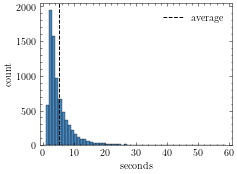

In [86]:
durations = clean_df["RTT(s)"]
no_afk_durations = durations[durations < 60]
unsure_duration = durations[(durations < 60) & (clean_df["chosen"] == "unsure")]
not_unsure_duration = durations[(durations < 60) & (clean_df["chosen"] != "unsure")]

print(f"average time for decision: {'{:.1f}'.format(no_afk_durations.mean())} seconds")

sns.histplot(data=clean_df,x="RTT(s)", bins=range(0, int(no_afk_durations.max()) + 1))
plt.gca().axvline(x=no_afk_durations.mean(), linestyle="--", color="k", label="average")

plt.xlim(left=-1, right=int(no_afk_durations.max()) + 2)
plt.ylim(bottom=0)

plt.xticks(ticks=[i*10 for i in range(7)])

plt.xlabel("seconds")
plt.ylabel("count")

plt.tight_layout()
plt.legend()
plt.savefig(plot_dir / "decision-duration.pdf")

In [28]:
useragents = []
for _, row in clean_df.iterrows():
    useragents.append(httpagentparser.detect(row["useragent"]))

browser_count = collections.Counter([val["browser"]["name"] for val in useragents])
os_count = collections.Counter([val["os"]["name"] for val in useragents])
dist_count = collections.Counter([val["dist"]["name"] for val in useragents if "dist" in val])

print(browser_count)
print(os_count)
print(dist_count)

Counter({'Chrome': 5031, 'Firefox': 2179, 'Safari': 533, 'Microsoft Internet Explorer': 174, 'MSEdge': 115})
Counter({'Windows': 6385, 'Macintosh': 981, 'Linux': 666})
Counter({'Ubuntu': 183, 'Android': 135})


In [29]:
usercount = clean_df[["userid", "hashval"]].rename(columns={"hashval": "count"}).groupby("userid").count()
print(f"average number of decisions: {'{:.1f}'.format(float(usercount.mean()))}")
print(usercount.nlargest(5, "count"))

average number of decisions: 110.0
                                  count
userid                                 
067d0ea51219886c5170c21a096493d6    561
962e15e995528855c89ad38d4141f7a8    491
6c76d477785b939dc316f12f4146bb5b    449
c88e8e7a6299a0812f609c8c2d5b36ae    396
e073e41ecf87df2f85a2db4770cc21fd    369


count    110.027397
dtype: float64

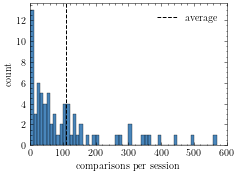

In [91]:
sns.histplot(data=usercount, bins=range(0, int(usercount.max()) + 11, 10), label="")
# sns.distplot(usercount, bins=range(0, int(usercount.max()) + 1, 10), hist_kws={"align": "left"})
plt.gca().axvline(x=float(usercount.mean()), linestyle="--", color="k", label="average")
# plt.yticks(range(0, 14))
plt.xlim(left=-1, right=int(usercount.max()) + 11)
plt.ylim(bottom=0)

plt.xlabel("comparisons per session")
plt.ylabel("count")

plt.xticks(ticks=[i*100 for i in range(7)])

plt.tight_layout()
plt.legend()
plt.savefig(plot_dir / "session-duration.pdf")
usercount.mean()

In [93]:
usercount.max()

count    561
dtype: int64